<a href="https://colab.research.google.com/github/Afzal-shaikh/reinforcement_assignment/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym~=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install tensorflow==2.11
!pip install pyvirtualdisplay
!pip install pyglet

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [21]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [22]:
from tf_agents.environments import suite_gym

env = suite_gym.load('LunarLander-v2')

In [23]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

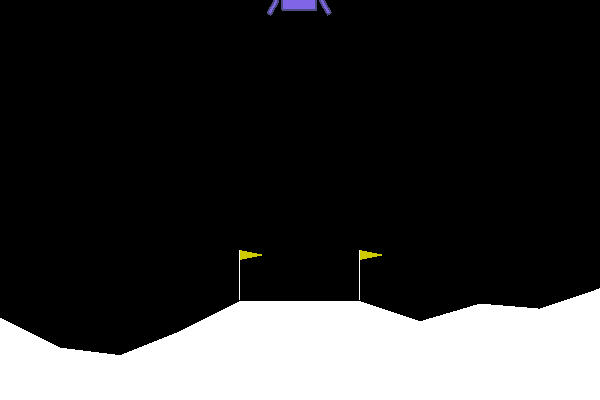

In [24]:
env.reset()
PIL.Image.fromarray(env.render())

In [25]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [26]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [27]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [28]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00374308,  1.4137986 ,  0.37911636,  0.12792097, -0.00433048,
       -0.08587547,  0.        ,  0.        ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0074151 ,  1.4161056 ,  0.3696905 ,  0.10253324, -0.00678579,
       -0.04910999,  0.        ,  0.        ], dtype=float32),
 'reward': array(1.1393477, dtype=float32),
 'step_type': array(1, dtype=int32)})


In [58]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [59]:
train_py_env = suite_gym.load('LunarLander-v2')
eval_py_env = suite_gym.load('LunarLander-v2')

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [60]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [62]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [63]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [64]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('LunarLander-v2'))

In [65]:
time_step = example_environment.reset()

In [66]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, state=(), info=())

In [67]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [68]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-202.87767

In [70]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

In [71]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(8,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [72]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [75]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 8), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [76]:
iterator = iter(dataset)
print(iterator)

In [80]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=4) # collect 4 steps for each training iteration


from tf_agents.eval.metric_utils import log_metrics


for _ in range(num_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(num_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:112.65930

INFO:absl: 
		 NumberOfEpisodes = 40
		 EnvironmentSteps = 4004
		 AverageReturn = -109.941162109375
		 AverageEpisodeLength = 82.9000015258789


1998 loss:49.75027

INFO:absl: 
		 NumberOfEpisodes = 51
		 EnvironmentSteps = 8004
		 AverageReturn = -149.18099975585938
		 AverageEpisodeLength = 337.70001220703125


2999 loss:25.45173

INFO:absl: 
		 NumberOfEpisodes = 55
		 EnvironmentSteps = 12004
		 AverageReturn = -141.82003784179688
		 AverageEpisodeLength = 560.0


3998 loss:17.67897

INFO:absl: 
		 NumberOfEpisodes = 60
		 EnvironmentSteps = 16004
		 AverageReturn = -204.61135864257812
		 AverageEpisodeLength = 904.7999877929688


4997 loss:1163.78076

INFO:absl: 
		 NumberOfEpisodes = 81
		 EnvironmentSteps = 20004
		 AverageReturn = -680.3724975585938
		 AverageEpisodeLength = 190.5


5999 loss:171.53665

INFO:absl: 
		 NumberOfEpisodes = 106
		 EnvironmentSteps = 24004
		 AverageReturn = -664.0145263671875
		 AverageEpisodeLength = 195.3000030517578


6998 loss:64.56642

INFO:absl: 
		 NumberOfEpisodes = 124
		 EnvironmentSteps = 28004
		 AverageReturn = -580.4025268554688
		 AverageEpisodeLength = 166.6999969482422


7997 loss:161.57950

INFO:absl: 
		 NumberOfEpisodes = 142
		 EnvironmentSteps = 32004
		 AverageReturn = -763.5363159179688
		 AverageEpisodeLength = 244.3000030517578


8998 loss:444.45972

INFO:absl: 
		 NumberOfEpisodes = 160
		 EnvironmentSteps = 36004
		 AverageReturn = -643.0206298828125
		 AverageEpisodeLength = 209.60000610351562


9997 loss:4429.52246

INFO:absl: 
		 NumberOfEpisodes = 180
		 EnvironmentSteps = 40004
		 AverageReturn = -640.485595703125
		 AverageEpisodeLength = 163.39999389648438


10997 loss:755.34003

INFO:absl: 
		 NumberOfEpisodes = 204
		 EnvironmentSteps = 44004
		 AverageReturn = -509.98193359375
		 AverageEpisodeLength = 164.60000610351562


11998 loss:881.22766

INFO:absl: 
		 NumberOfEpisodes = 228
		 EnvironmentSteps = 48004
		 AverageReturn = -772.5462036132812
		 AverageEpisodeLength = 179.6999969482422


12997 loss:32043.97852

INFO:absl: 
		 NumberOfEpisodes = 244
		 EnvironmentSteps = 52004
		 AverageReturn = -672.1407470703125
		 AverageEpisodeLength = 260.79998779296875


13998 loss:288.14130

INFO:absl: 
		 NumberOfEpisodes = 254
		 EnvironmentSteps = 56004
		 AverageReturn = -1056.455810546875
		 AverageEpisodeLength = 414.6000061035156


14999 loss:389.29187

INFO:absl: 
		 NumberOfEpisodes = 264
		 EnvironmentSteps = 60004
		 AverageReturn = -670.8002319335938
		 AverageEpisodeLength = 383.0


15997 loss:1586.58350

INFO:absl: 
		 NumberOfEpisodes = 277
		 EnvironmentSteps = 64004
		 AverageReturn = -621.2447509765625
		 AverageEpisodeLength = 327.70001220703125


16997 loss:683.13214

INFO:absl: 
		 NumberOfEpisodes = 290
		 EnvironmentSteps = 68004
		 AverageReturn = -541.3784790039062
		 AverageEpisodeLength = 325.3999938964844


17999 loss:14917.24219

INFO:absl: 
		 NumberOfEpisodes = 301
		 EnvironmentSteps = 72004
		 AverageReturn = -487.31036376953125
		 AverageEpisodeLength = 356.1000061035156


18998 loss:589.55249

INFO:absl: 
		 NumberOfEpisodes = 312
		 EnvironmentSteps = 76004
		 AverageReturn = -809.5801391601562
		 AverageEpisodeLength = 328.3999938964844


19999 loss:948.70593

INFO:absl: 
		 NumberOfEpisodes = 324
		 EnvironmentSteps = 80004
		 AverageReturn = -1107.1058349609375
		 AverageEpisodeLength = 285.6000061035156


999 loss:40166.27344

INFO:absl: 
		 NumberOfEpisodes = 350
		 EnvironmentSteps = 84004
		 AverageReturn = -672.0318603515625
		 AverageEpisodeLength = 123.4000015258789


1997 loss:12904.73047

INFO:absl: 
		 NumberOfEpisodes = 374
		 EnvironmentSteps = 88004
		 AverageReturn = -1047.0740966796875
		 AverageEpisodeLength = 169.3000030517578


2999 loss:15890.94629

INFO:absl: 
		 NumberOfEpisodes = 404
		 EnvironmentSteps = 92004
		 AverageReturn = -899.81005859375
		 AverageEpisodeLength = 136.39999389648438


3998 loss:33760.00000

INFO:absl: 
		 NumberOfEpisodes = 430
		 EnvironmentSteps = 96004
		 AverageReturn = -548.1636962890625
		 AverageEpisodeLength = 106.4000015258789


4997 loss:39685.73438

INFO:absl: 
		 NumberOfEpisodes = 460
		 EnvironmentSteps = 100004
		 AverageReturn = -552.7630004882812
		 AverageEpisodeLength = 120.19999694824219


5999 loss:359793.75000

INFO:absl: 
		 NumberOfEpisodes = 485
		 EnvironmentSteps = 104004
		 AverageReturn = -658.3072509765625
		 AverageEpisodeLength = 138.89999389648438


6998 loss:580617.93750

INFO:absl: 
		 NumberOfEpisodes = 511
		 EnvironmentSteps = 108004
		 AverageReturn = -653.8701171875
		 AverageEpisodeLength = 158.6999969482422


7997 loss:23075.23242

INFO:absl: 
		 NumberOfEpisodes = 530
		 EnvironmentSteps = 112004
		 AverageReturn = -736.3297119140625
		 AverageEpisodeLength = 213.0


8999 loss:39362.54688

INFO:absl: 
		 NumberOfEpisodes = 549
		 EnvironmentSteps = 116004
		 AverageReturn = -741.25390625
		 AverageEpisodeLength = 214.6999969482422


9997 loss:25477.87891

INFO:absl: 
		 NumberOfEpisodes = 569
		 EnvironmentSteps = 120004
		 AverageReturn = -646.32470703125
		 AverageEpisodeLength = 172.60000610351562


10998 loss:924839.50000

INFO:absl: 
		 NumberOfEpisodes = 586
		 EnvironmentSteps = 124004
		 AverageReturn = -951.1920776367188
		 AverageEpisodeLength = 302.3999938964844


11999 loss:69521.71094

INFO:absl: 
		 NumberOfEpisodes = 598
		 EnvironmentSteps = 128004
		 AverageReturn = -690.3816528320312
		 AverageEpisodeLength = 292.79998779296875


12997 loss:1388202.25000

INFO:absl: 
		 NumberOfEpisodes = 609
		 EnvironmentSteps = 132004
		 AverageReturn = -731.892578125
		 AverageEpisodeLength = 363.6000061035156


13998 loss:45282.07031

INFO:absl: 
		 NumberOfEpisodes = 620
		 EnvironmentSteps = 136004
		 AverageReturn = -955.6232299804688
		 AverageEpisodeLength = 375.29998779296875


14997 loss:27966.43750

INFO:absl: 
		 NumberOfEpisodes = 634
		 EnvironmentSteps = 140004
		 AverageReturn = -545.0158081054688
		 AverageEpisodeLength = 278.3999938964844


15999 loss:21296.80273

INFO:absl: 
		 NumberOfEpisodes = 645
		 EnvironmentSteps = 144004
		 AverageReturn = -789.7206420898438
		 AverageEpisodeLength = 353.20001220703125


16997 loss:26618.50000

INFO:absl: 
		 NumberOfEpisodes = 656
		 EnvironmentSteps = 148004
		 AverageReturn = -508.90008544921875
		 AverageEpisodeLength = 386.79998779296875


17998 loss:19192.73828

INFO:absl: 
		 NumberOfEpisodes = 664
		 EnvironmentSteps = 152004
		 AverageReturn = -673.8842163085938
		 AverageEpisodeLength = 452.3999938964844


18998 loss:821933.31250

INFO:absl: 
		 NumberOfEpisodes = 674
		 EnvironmentSteps = 156004
		 AverageReturn = -845.6311645507812
		 AverageEpisodeLength = 398.70001220703125


19998 loss:142853.62500

INFO:absl: 
		 NumberOfEpisodes = 682
		 EnvironmentSteps = 160004
		 AverageReturn = -603.2645263671875
		 AverageEpisodeLength = 470.29998779296875


998 loss:22036.95508

INFO:absl: 
		 NumberOfEpisodes = 692
		 EnvironmentSteps = 164004
		 AverageReturn = -825.0173950195312
		 AverageEpisodeLength = 415.79998779296875


1997 loss:19673.66406

INFO:absl: 
		 NumberOfEpisodes = 701
		 EnvironmentSteps = 168004
		 AverageReturn = -638.626220703125
		 AverageEpisodeLength = 424.1000061035156


2999 loss:27952.20508

INFO:absl: 
		 NumberOfEpisodes = 709
		 EnvironmentSteps = 172004
		 AverageReturn = -655.0856323242188
		 AverageEpisodeLength = 514.7000122070312


3998 loss:20611.11719

INFO:absl: 
		 NumberOfEpisodes = 716
		 EnvironmentSteps = 176004
		 AverageReturn = -566.7396240234375
		 AverageEpisodeLength = 538.4000244140625


4998 loss:29323.46289

INFO:absl: 
		 NumberOfEpisodes = 726
		 EnvironmentSteps = 180004
		 AverageReturn = -801.40234375
		 AverageEpisodeLength = 435.3999938964844


5997 loss:34323.77344

INFO:absl: 
		 NumberOfEpisodes = 734
		 EnvironmentSteps = 184004
		 AverageReturn = -737.4431762695312
		 AverageEpisodeLength = 464.0


6998 loss:1189426.25000

INFO:absl: 
		 NumberOfEpisodes = 742
		 EnvironmentSteps = 188004
		 AverageReturn = -685.1698608398438
		 AverageEpisodeLength = 487.3999938964844


7997 loss:48674.00781

INFO:absl: 
		 NumberOfEpisodes = 750
		 EnvironmentSteps = 192004
		 AverageReturn = -627.6983642578125
		 AverageEpisodeLength = 507.70001220703125


8997 loss:17062.72461

INFO:absl: 
		 NumberOfEpisodes = 758
		 EnvironmentSteps = 196004
		 AverageReturn = -538.1753540039062
		 AverageEpisodeLength = 519.7999877929688


9997 loss:12255.93066

INFO:absl: 
		 NumberOfEpisodes = 766
		 EnvironmentSteps = 200004
		 AverageReturn = -1284.028076171875
		 AverageEpisodeLength = 544.0


10998 loss:24765.19922

INFO:absl: 
		 NumberOfEpisodes = 773
		 EnvironmentSteps = 204004
		 AverageReturn = -988.6407470703125
		 AverageEpisodeLength = 512.0


11999 loss:18796.97852

INFO:absl: 
		 NumberOfEpisodes = 783
		 EnvironmentSteps = 208004
		 AverageReturn = -656.2778930664062
		 AverageEpisodeLength = 432.6000061035156


12998 loss:21264.71484

INFO:absl: 
		 NumberOfEpisodes = 791
		 EnvironmentSteps = 212004
		 AverageReturn = -1290.48974609375
		 AverageEpisodeLength = 520.9000244140625


13998 loss:42079.81250

INFO:absl: 
		 NumberOfEpisodes = 802
		 EnvironmentSteps = 216004
		 AverageReturn = -965.3460083007812
		 AverageEpisodeLength = 361.79998779296875


14999 loss:321224.81250

INFO:absl: 
		 NumberOfEpisodes = 837
		 EnvironmentSteps = 220004
		 AverageReturn = -343.50091552734375
		 AverageEpisodeLength = 90.30000305175781


15999 loss:2962230.25000

INFO:absl: 
		 NumberOfEpisodes = 878
		 EnvironmentSteps = 224004
		 AverageReturn = -702.25634765625
		 AverageEpisodeLength = 124.0999984741211


16997 loss:2354510.75000

INFO:absl: 
		 NumberOfEpisodes = 916
		 EnvironmentSteps = 228004
		 AverageReturn = -598.3436889648438
		 AverageEpisodeLength = 100.9000015258789


17998 loss:3170419968.00000

INFO:absl: 
		 NumberOfEpisodes = 946
		 EnvironmentSteps = 232004
		 AverageReturn = -874.5178833007812
		 AverageEpisodeLength = 140.3000030517578


18997 loss:3685522.00000

INFO:absl: 
		 NumberOfEpisodes = 979
		 EnvironmentSteps = 236004
		 AverageReturn = -594.6182861328125
		 AverageEpisodeLength = 98.9000015258789


19999 loss:38621836.00000

INFO:absl: 
		 NumberOfEpisodes = 1008
		 EnvironmentSteps = 240004
		 AverageReturn = -894.1331787109375
		 AverageEpisodeLength = 157.60000610351562


997 loss:12808826.00000

INFO:absl: 
		 NumberOfEpisodes = 1035
		 EnvironmentSteps = 244004
		 AverageReturn = -869.3602294921875
		 AverageEpisodeLength = 141.1999969482422


1998 loss:5831336.00000

INFO:absl: 
		 NumberOfEpisodes = 1063
		 EnvironmentSteps = 248004
		 AverageReturn = -948.8543090820312
		 AverageEpisodeLength = 171.39999389648438


3000 loss:6175832.50000

INFO:absl: 
		 NumberOfEpisodes = 1091
		 EnvironmentSteps = 252004
		 AverageReturn = -643.9649047851562
		 AverageEpisodeLength = 138.5


3999 loss:4438471680.00000

INFO:absl: 
		 NumberOfEpisodes = 1120
		 EnvironmentSteps = 256004
		 AverageReturn = -610.79296875
		 AverageEpisodeLength = 132.89999389648438


4260 loss:6559759.50000

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  '''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-agent")